# 1. Calculating with sets: Interval arithmetic

The numerical methods that we will look at today have the goal of obtaining **guaranteed results** to numerical calculations -- the kind of calculations that you would usually do with floating-point arithmetic.

The goal of the workshop is to introduce the ideas behind the methods and to illustrate them using the packages in the [JuliaIntervals](https://github.com/JuliaIntervals) organization, which are all build on `IntervalArithmetic.jl`, a pure-Julia (almost) package which is competitive with state-of-the-art packages in other languages.

Since this is a worshop, there will be a series of exercises for you to do during the workshop. We will not have time to cover all the exercises; think of the remainder as homework to do later on to reinforce the ideas!

As a motivating example, let's look at the following function, which is an example by the eminent numerical analyst William Kahan:

In [1]:
f(x) = (1/80) * log(abs(3*(1 - x) + 1)) + x^2 + 1

f (generic function with 1 method)

In [42]:
import Pkg;
Pkg.add("Plots");
using Plots

  Resolving package versions...
No Changes to `~/repo/enviro-repo/osx-base/dotfiles/.julia/environments/v1.5/Project.toml`
No Changes to `~/repo/enviro-repo/osx-base/dotfiles/.julia/environments/v1.5/Manifest.toml`


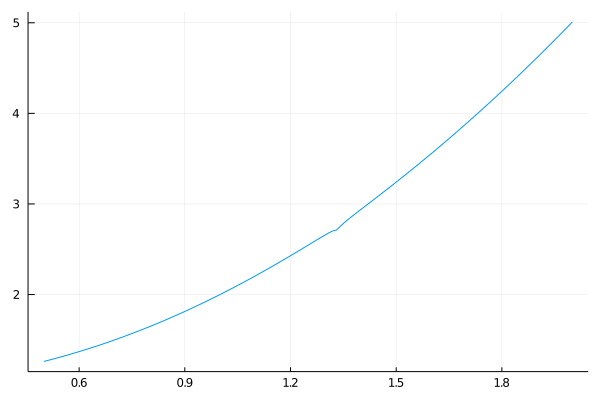

In [43]:
plot(0.5:0.01:2.0, f, leg=false)

The function looks smooth except for a little blip around 1.3.
Let's sample more values there to see what's going on:

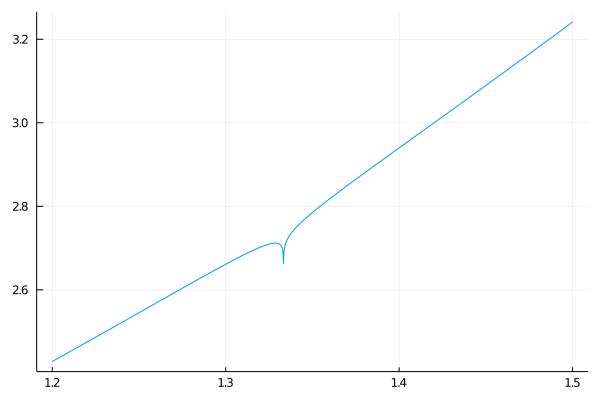

In [44]:
plot(1.2:0.0001:1.5, f, leg=false)

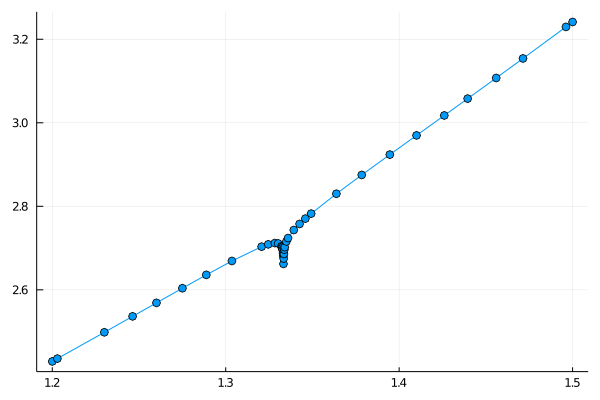

In [46]:
plot(f, 1.2, 1.5, leg=false, m=:o)

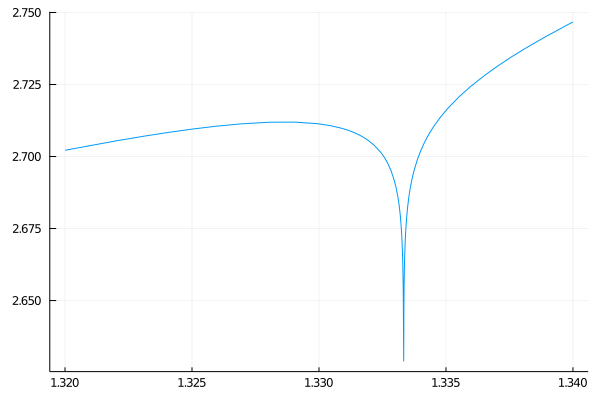

In [45]:
plot(f, 1.32, 1.34, leg=false)

It looks like there's a cusp. If we stare at the original function we see that in fact... the function diverges to $-\infty$ at $x=4/3$. 

But $4/3$ is not representable as a floating-point number. Let's look at the nearest floating-point numbers using `Float64`:

In [12]:
x = 4//3

4//3

In [13]:
typeof(x)

Rational{Int64}

In [11]:
RoundDown

RoundingMode{:Down}()

In [14]:
x = Float64(4//3, RoundDown)

1.3333333333333333

In [15]:
f(x)

2.327232110413813

In [16]:
nextfloat(x)

1.3333333333333335

In [17]:
eps(x)   # 1 ulp -- unit in the last place

2.220446049250313e-16

In [18]:
f(nextfloat(x))

2.335896450170813

So between these two neighbouring floating-point numbers the function dashes down to $-\infty$ and back. And (if we stick to `Float64`) we can *never* see this. Even changing to `BigFloat` doesn't help too much:

In [19]:
precision(BigFloat)

256

In [20]:
x = BigFloat(4//3, RoundDown)

1.333333333333333333333333333333333333333333333333333333333333333333333333333322

In [21]:
f(x)

0.5770354794999512982123272514217265634115132219274471953590374066727810071599333

In [22]:
f(nextfloat(x))

0.5683711397429519813636443753337106137486539126524458938534518146605566104252715

In [23]:
eps(x)

1.727233711018888925077270372560079914223200072887256277004740694033718360632485e-77

In [24]:
setprecision(BigFloat, 1000)

1000

In [25]:
x = BigFloat(4//3, RoundDown);

In [26]:
f(x)

-5.86923329970754043720773255806213998575581287867352112479664305042217016346855757418824144180042278882897083191617522225023298663542663717982026301197690165953698040686666845751584215835791617144050190913370913975685802651733399523189081753310559658663757734849055984142394616142666629628381875938552424

In [27]:
f(4//3)

-Inf

In [26]:
log(0.0)

-Inf

In [28]:
sin(pi)

1.2246467991473532e-16

In [28]:
log(sin(pi))

-36.63870901270898

What we need is a way to be able to calculate $f(x)$ for *all* real $x$ in a certain *interval* (a set), say 
$X := [1.2,  1.5]$. That is, we want to calculate the **range** of $f$ over the input set $X$, which we will denote as $\text{range}(f; X)$. If $X$ is a closed, bounded interval and $f$ is a continuous function then the range is also a closed and bounded interval. 

Standard numerical methods do not provide *any* way to calculate this. Calculating it exactly is equivalent to the problem of **global optimization**, which is "very hard". But also, as we saw above, standard numerical methods, based on calculating with single floating-point numbers, are incapable of saying anything about the behaviour of a function near to a given point.

Interval arithmetic provides a way to calculate with sets of this kind. Its main contribution is to give a simple, computationally cheap method to calculate the range of $f$, or rather, an **over-approximation** of the range -- i.e. some interval $Y$ such that $\text{range}(f; X) \subseteq Y$. This is often called an **enclosure** of the range (since it is a set that encloses the true range).

Similar ideas have been rediscovered repeatedly, but the blossoming of the field happened in the 1960s, naturally tied to the advent of the digital computer. Since then, many methods have been developed, based on this apparently simple idea of calculating the range of a function over a set.

Some of the methods that we will look at enable us to:
- find all simple roots of a function $\mathbb{R}^n \to \mathbb{R}$ in a box, and prove that the result is correct;
- find the global minimum and all minimizers of a general nonlinear (possibly discontinuous) function;
- find the feasible set that satisfies certain constraints;
- integrate an ordinary differential equation and provide a tube that is guaranteed to contain the true solution.

## Intervals

By **interval** we will always mean a closed interval $\{x \in \mathbb{R}: a \le x \le b \} \subseteq \overline{\mathbb{R}}$, where $\overline{\mathbb{R}}$ means the extended real line including $\pm \infty$.
[Allowing open intervals does not add much and complicates everything.]

An interval is simply defined by its lower and upper end-points, which we will call `lo` and `hi` for brevity. (Better names might be `min` and `max`, or `inf` and `sup`.)

#### Exercise

1. Make a `MyInterval` type containing a `lo` and `hi` field. It should have an inner contractor that ensures that the order is correct. Either assume that `lo` and `hi` are of type `Float64`, or paramatrise the type.

## Main idea of interval arithmetic

Suppose we have a complicated function like $f(x) = \exp(x^2 + 1) - x^2$. We can split this up into a series of elementary functions like $+$ and $\exp$. In fact, Julia effectively does this for us:

In [29]:
ex = :(exp(x^2 + 1) - x^2)
dump(ex)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol -
    2: Expr
      head: Symbol call
      args: Array{Any}((2,))
        1: Symbol exp
        2: Expr
          head: Symbol call
          args: Array{Any}((3,))
            1: Symbol +
            2: Expr
              head: Symbol call
              args: Array{Any}((3,))
                1: Symbol ^
                2: Symbol x
                3: Int64 2
            3: Int64 1
    3: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol ^
        2: Symbol x
        3: Int64 2


We can visualize this as an **expression graph** or **abstract syntax tree** using the `TreeView.jl` package that I wrote:

In [33]:
Pkg.add("TreeView");
using TreeView


  Resolving package versions...
No Changes to `~/repo/enviro-repo/osx-base/dotfiles/.julia/environments/v1.5/Project.toml`
No Changes to `~/repo/enviro-repo/osx-base/dotfiles/.julia/environments/v1.5/Manifest.toml`


In [34]:
@tree exp(x^2 + 1) - x^2

LabelledTree({10, 9} directed simple Int64 graph, Any[:-, :exp, :+, :^, :x, 2, 1, :^, :x, 2])

Note that $x^2$ occurs twice. We can redraw the graph using **common subexpression elimination** (CSE):

In [35]:
@dag_cse exp(x^2 + 1) - x^2

TreeView.DirectedAcyclicGraph({7, 7} directed simple Int64 graph, Any[:^, :x, 2, :+, 1, :exp, :-], Dict(Symbol("##260") => 7,Symbol("##257") => 1,Symbol("##258") => 4,Symbol("##259") => 6,:x => 2))

We can think of evaluating this expression by introducing new variables at each node of the graph, from bottom to top:

In [36]:
f(x) = exp(x^2 + 1) - x^2

f (generic function with 1 method)

In [37]:
x = 1.3

a = x^2
b = a + 1
c = exp(b)
d = c - a

13.041675920442577

Let's check that the answer is correct:

In [ ]:
f(x)

The idea to bound the range of the full function $f$ over an input set $X$ is to do it piece by piece: for each elementary function $\phi$ we calculate analytically (by hand) the range of $\phi$ over any input interval $[a, b]$.

In the above example, we start from an initial input interval $X = [1.2, 1.3]$, say.
Once we know how to calculate the range of elementary functions, we can first calculate the range of the function $x \mapsto x^2$, i.e. calculate $x^2$ for all $x \in X$. 

We will denote the result of this calculation by $X^2$, i.e. the **square of the *set* $X$**. This is an operation that is not usually allowed or of interest in "standard" mathematics; we are free to define it in a useful way. 

In general, for an interval $X$ and a function $g$, we define $g(X)$ to mean "the (hopefully smallest) interval that we can calculate such that it contains $g(x)$ for all $x \in X$".

This definition is not useful for actually *calculating* the range; we instead need an **operational** definition, i.e. one which can actually be used.
To do so, we ask "what are the smallest and largest possible values that can be produced?" These give us the range.

#### Exercise

1. How can you define $\exp(X)$ for an interval $X = [a, b]$? Hint: What property does the function $\exp$ have? So what is the range?


2. Implement this.


3. How can you calculate $[1, 4]^2$?


4. How can you calculate $[a, b]^2$ for an *arbitrary* interval $X$? What is the difficulty?


5. Implement this.

## Arithmetic

We can proceed similarly for functions of two variables like $+$ and $*$, e.g. we *define* 
$X + Y$ to mean $\{x + y: x \in X \text{ and } y \in Y \}$, i.e. the set of *all possible sums* where one summand belongs to one of the sets and the other belongs to the second set.

Again, this definition is not useful for actually *calculating*. We instead need an **operational** definition.
To do so, we ask "what are the smallest and largest possible values that can be produced?" These give us the range.

#### Exercise 

1. What are the smallest and largest possible values that $X + Y$ can take?


2. Implement this.


3. What about for subtraction? Multiplication?  E.g. what is $[-1, 2] \times [-4, -3]$?

     You will find it useful to write a (non-rigorous) function that *samples* many points from $X$ and from $Y$ and does the operation on them, then finds the bounds on the interval that encloses all the calculated values, to compare your results with.

## Directed rounding

There is a problem with the operations that we are defining: they may not give the right answer! That is, they may give a result that is very slightly wrong, due to the way in which floating-point arithmetic works. E.g.:

In [ ]:
x, y = 0.1, 0.3

x + y

This seems correct. But recall that `0.1` does not mean what you think it does. The true real number $1/10$ is not exactly representable as a floating-point number (with any precision) [and base 2]. Instead, `0.1` represents the following exact real number:

In [ ]:
big(x)

The true value of the sum of these two floating-point numbers is thus

In [ ]:
big(x) + big(y)

whereas Julia returns the following floating-point number:

In [ ]:
big(x + y)

What is happening here? Even though we are summing two floating-point numbers, the result is *not* exactly representable as a `Float64`, so Julia must perform **rounding**: it gives the *nearest* floating-point number to the true result. [The CPU does this by using a couple of extra digits internally in the calculation.]

However, if this is supposed to be the lower end-point of an interval, we see that the result *excludes* a (tiny) interval of possible values.

To solve this, we need to use **directed** or **outward** rounding: the lower endpoint of the result should be rounded *downwards* (towards $-\infty$), while the upper endpoint should be rounded *upwards*.

There are various ways in which this can be done. We will use the simplest: use the `prevfloat` function on the result of the lower endpoint, and `nextfloat` on the upper endpoint. Note that this often gives a very slightly *wider* interval than is actually necessary, but doing better is much harder. [GPUs have built-in arithmetic operations including the different rounding modes, but CPUs do not.]

#### Exercise

1. Implement addition with directed rounding.

## The fundamental theorem of interval arithmetic

The fundamental theorem of interval arithmetic is the following idea: For a complicated function $f$, write it in terms of elementary functions as we did above.

> Once we have a way of calculating enclosures for the range of each elementary function, we just do each calculation using interval arithmetic. Since at each step we guarantee to enclose the true range, the end result of the calculation is a guaranteed enclosure for the range of the original function $f$ !

## The dependency problem

It sounds like we have solved the whole problem of calculating the range of a general function. But unfortunately this is not the case. For example, let $X = [0, 1]$. What is $X - X$?

We would like the result to be $\{ x - x: x \in X \}$, which gives the single-element set $\{0\}$. But interval arithmetic "does not know" that the two $X$s in the expression refer to the same object, and instead calculates
$X - Y$ where $X$ and $Y$ are "independent" copies of $[0, 1]$. It calculates $\{ x - y: x, y \in X \}$ and gives the result $[-1, 1]$.

Of course, $[-1, 1]$ contains the true result, but it is a vast *over*-estimate. This is known as the **dependency problem**, since it arises when different terms in an expression are not independent of each other -- basically, when two or more terms involve the *same* variable. [It can be shown that if each variable in an expression occurs only *once* then the resulting range *is* exact.]

## Challenge problem

Implement a full set of interval arithmetic operations, $+$, $*$, $-$, $/$, $\sqrt{}$. For a real challenge try $\sin(X)$.